<a href="https://colab.research.google.com/github/nerdk312/Multimodal_VQ-VAE/blob/master/110120_Either_modality_missing_remove_patch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
# Nawid - Updates the path to import from drive
import sys
sys.path.append('/content/gdrive/My Drive/vq-vae-2-master-Single_representation_V4')

import itertools
import os

from PIL import Image
from PIL import ImageOps
from keras.preprocessing import image as image_utils
import numpy as np
import torch
import torchvision
import torch.optim as optim
from tensorboardcolab import TensorBoardColab
from torch.utils.data import DataLoader
import random

# Nawid - Used to get the current time and date which I will use the save the data in a folder
from datetime import datetime

from vq_vae_2.examples.hierarchical_combined.model import make_vae
target_size = (128,128)

Using TensorFlow backend.


In [3]:
def common_images(RGB_dir,Thermal_dir):
  RGB_image_list = os.listdir(RGB_dir)
  Thermal_image_list = os.listdir(Thermal_dir)

  truncated_RGB_image_list = [RGB_image_name.strip('.jpg') for RGB_image_name in RGB_image_list]
  truncated_Thermal_image_list = [Thermal_image_name.strip('.jpeg') for Thermal_image_name in Thermal_image_list]

  common_list = set(truncated_RGB_image_list).intersection(truncated_Thermal_image_list)
  common_list = sorted(common_list) # Nawid - Sorts all the items in a list
  return common_list

RGB_inp_dir = '/content/gdrive/My Drive/RGB'
Thermal_inp_dir = '/content/gdrive/My Drive/thermal_8_bit'
train_list = common_images(RGB_inp_dir,Thermal_inp_dir) 

val_RGB_inp_dir = '/content/gdrive/My Drive/Val_RGB'
val_Thermal_inp_dir = '/content/gdrive/My Drive/Val_thermal_8_bit'
val_list = common_images(val_RGB_inp_dir,val_Thermal_inp_dir)

def processing_saving_images(modality,quick_test=True,Train_required=False,Val_required=True):
  all_images = []
  val_all_images = []
  
  if modality == 'RGB_':
    suffix = '.jpg'
    channels = 3
    inp_dir = '/content/gdrive/My Drive/RGB'
    val_inp_dir = '/content/gdrive/My Drive/Val_RGB'
  
  elif modality == 'Thermal_':
    suffix = '.jpeg'
    channels = 1
    inp_dir = '/content/gdrive/My Drive/thermal_8_bit'
    val_inp_dir = '/content/gdrive/My Drive/Val_thermal_8_bit'
  
  else:
    return('Incorrect Modality name')

  if quick_test:
    if Train_required:
      for i, img_name in enumerate(train_list):
        if i< 10:
          fname = inp_dir + '/' + img_name + suffix
          if modality == 'RGB_':
            image = image_utils.load_img(fname).resize(target_size,Image.ANTIALIAS)
          else:
            image = image_utils.load_img(fname,color_mode='grayscale').resize(target_size,Image.ANTIALIAS)
          image = np.array(image.getdata()).reshape(target_size[0], target_size[1], channels)
          image_flipped = np.fliplr(image)
          image = image.astype('float32')/255
          image_flipped = image_flipped.astype('float32')/255 
          all_images.append(image)
          all_images.append(image_flipped)
        else:
          pass
    else:
      pass
    
    if Val_required:
      for j, img_name in enumerate(val_list):
        if j < 10:
          fname = val_inp_dir + '/' + img_name + suffix
          if modality == 'RGB_':
            image = image_utils.load_img(fname).resize(target_size,Image.ANTIALIAS)
          else:
            image = image_utils.load_img(fname,color_mode='grayscale').resize(target_size,Image.ANTIALIAS)
          
          image = np.array(image.getdata()).reshape(target_size[0], target_size[1], channels)
          image_flipped = np.fliplr(image)
          image = image.astype('float32')/255
          image_flipped = image_flipped.astype('float32')/255 
          val_all_images.append(image)
          val_all_images.append(image_flipped)
        else: 
          pass 
    else:
      pass

  else:
    if Train_required:
      for i, img_name in enumerate(train_list):
        fname = inp_dir + '/' + img_name + suffix
        if modality == 'RGB_':
          image = image_utils.load_img(fname).resize(target_size,Image.ANTIALIAS)
        else:
          image = image_utils.load_img(fname,color_mode='grayscale').resize(target_size,Image.ANTIALIAS)
        image = np.array(image.getdata()).reshape(target_size[0], target_size[1], channels)
        image_flipped = np.fliplr(image)
        image = image.astype('float32')/255
        image_flipped = image_flipped.astype('float32')/255 
        all_images.append(image)
        all_images.append(image_flipped)
        if not i%100:
          print(i)
        else: 
          pass
    else:
      pass
  
    if Val_required:
      for j, img_name in enumerate(val_list):
        fname = val_inp_dir + '/' + img_name + suffix
        if modality == 'RGB_':
          image = image_utils.load_img(fname).resize(target_size,Image.ANTIALIAS)
        else:
          image = image_utils.load_img(fname,color_mode='grayscale').resize(target_size,Image.ANTIALIAS)
        
        image = np.array(image.getdata()).reshape(target_size[0], target_size[1], channels)
        image_flipped = np.fliplr(image)
        image = image.astype('float32')/255
        image_flipped = image_flipped.astype('float32')/255 
        val_all_images.append(image)
        val_all_images.append(image_flipped)
        if not j%100:
          print(j)
        else: 
          pass
    else:
      pass

  if Train_required: 
    np.save('/content/gdrive/My Drive/' + modality +str(target_size[0]) + 'x' + str(target_size[1]) + '_images.npy',all_images)

  if Val_required:
    np.save('Val_'+modality +str(target_size[0]) + 'x' + str(target_size[1]) + '_images.npy',val_all_images)

rgb_modality = 'RGB_'
thermal_modality = 'Thermal_'

processing_saving_images(rgb_modality,quick_test=False,Train_required=True,Val_required=False)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300


# Uploading from drive directly

In [4]:
upload_directly = True
if upload_directly:
  x_rgb = np.load('/content/gdrive/My Drive/RGB_'+str(target_size[0]) + 'x' + str(target_size[1]) + '_images.npy')
  val_x_rgb = np.load('/content/gdrive/My Drive/Val_RGB_'+str(target_size[0]) + 'x' + str(target_size[1]) + '_images.npy')
  x = np.load('/content/gdrive/My Drive/Thermal_'+str(target_size[0]) + 'x' + str(target_size[1]) + '_images.npy')
  val_x = np.load('/content/gdrive/My Drive/Val_Thermal_'+str(target_size[0]) + 'x' + str(target_size[1]) + '_images.npy')
else:
  x_rgb = np.load('/content/RGB_'+str(target_size[0]) + 'x' + str(target_size[1]) + '_images.npy')
  val_x_rgb = np.load('/content/Val_RGB_'+str(target_size[0]) + 'x' + str(target_size[1]) + '_images.npy')
  x = np.load('/content/Thermal_'+str(target_size[0]) + 'x' + str(target_size[1]) + '_images.npy')
  val_x = np.load('/content/Val_Thermal_'+str(target_size[0]) + 'x' + str(target_size[1]) + '_images.npy')

#val_x = val_x[:len(val_x_rgb)] # Nawid - Make into the same size as the limiting case
print(x_rgb.shape)
print(val_x_rgb.shape)
print(x.shape)
print(val_x.shape)

(16726, 128, 128, 3)
(2514, 128, 128, 3)
(16726, 128, 128, 1)
(2514, 128, 128, 1)


# Model config

In [0]:
BATCH_SIZE = 32

log_interval = 50
rapid_evaluation = False
eval_counter = 50
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
noisy_pixels = 200 # Nawid - Number of pixels to flip
missing_value = 0.5 # Nawid - Value to choose to represent the missing modality
#VAE_PATH_SAVE = 'vae.pt'
#VAE_PATH = 'vae.pt'
#VAE_PATH = '/content/gdrive/My Drive/vae_cycle1_training.pt'
# Nawid - Used to ensure the results are reproducible - https://pytorch.org/docs/stable/notes/randomness.html


reproducible = True # Nawid - Set so results are reproducible
seed_value = 0
if reproducible:
  torch.manual_seed(seed_value)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False
  np.random.seed(seed_value)

#missing_threshold = 0.3

save_data = False
if save_data:
  tb = TensorBoardColab() # Nawid - Creates a tensorboard link 

# Data loader functions

In [0]:
def missing_modality_output(modal_input,defect):
  target = modal_input.clone() # Nawid - The target is the input before it has been modified - Need to clone it otherwise the changes to the modal_input later on is carried through
  if defect == 0: # Nawid - PATCH
    modal_input[:,:,target_size[0]//2 - 25:target_size[0]//2 + 25, target_size[1]//2 - 25: target_size[1]//2 + 25] = missing_value
  elif defect == 1: # Nawid - Need to add the flipped pixel at some point
    height_list = [random.randint(0,target_size[0]-1) for i in range(noisy_pixels)]
    width_list = [random.randint(0,target_size[1]-1) for i in range(noisy_pixels)]
    modal_input[:,:,height_list,width_list] = missing_value

  elif defect ==2: # Nawid - Missing modality
    modal_input = modal_input.new_full((modal_input.size()),missing_value) #  Nawid- Overwrite modal input so that the modality is completely missing 
  return modal_input, target

class ConcatDataset(torch.utils.data.Dataset):
    def __init__(self, *datasets):
        self.datasets = datasets

    def __getitem__(self, i):
        return tuple(d[i] for d in self.datasets)

    def __len__(self):
        return min(len(d) for d in self.datasets)

def rgb_thermal_data_loader(input_rgb,input_thermal): # Nawid - Creates a dataloader object
    return torch.utils.data.DataLoader(ConcatDataset(input_rgb,input_thermal),batch_size=BATCH_SIZE, shuffle = True)

def rgb_thermal_load_images(input_rgb, input_thermal): # Nawid - Loads images
    while True:
        for (rgb_data,thermal_data) in rgb_thermal_data_loader(input_rgb,input_thermal):
          #data = data.float()/255 # Nawid - Divides by 255 
          rgb_data = rgb_data.permute(0, 3, 1, 2).contiguous() # Nawid - Changes into pytorch ordering
          thermal_data = thermal_data.permute(0, 3, 1, 2).contiguous()
          yield rgb_data, thermal_data

# https://gist.github.com/MFreidank/821cc87b012c53fade03b0c7aba13958
class InfiniteDataLoader(DataLoader): 
  def __init__(self,input_rgb,input_thermal, batch_size=BATCH_SIZE, shuffle=True):
    super().__init__(ConcatDataset(input_rgb,input_thermal), batch_size=BATCH_SIZE, shuffle=True) # Nawid - Instantiates the dataloader subclass using a concatenated input

    #Initialise an iterator over the dataset
    self.dataset_iterator = super().__iter__()

  def __iter__(self):
    return self

  def __next__(self,Missing= False, Missing_modality =None,Defect = None): # Nawid - Added the Missing term here
    try:
      batch = next(self.dataset_iterator)
      
    except StopIteration:
      # Dataset exhausted, use a new fresh iterator
      self.dataset_iterator = super().__iter__()
      batch = next(self.dataset_iterator)

    rgb_batch, thermal_batch = batch[0], batch[1] # Nawid- Obtains the different values in the batch
    rgb_batch = rgb_batch.permute(0, 3, 1, 2).contiguous() # Nawid- Added this to change the channels - Change to pytorch ordering
    thermal_batch = thermal_batch.permute(0, 3, 1, 2).contiguous()
    
    if Missing:
      if Missing_modality == 'Thermal':
        thermal_batch, target_modality = missing_modality_output(thermal_batch,Defect)
      elif Missing_modality == 'RGB':
        rgb_batch, target_modality = missing_modality_output(rgb_batch,Defect)
      return rgb_batch.to(device), thermal_batch.to(device), target_modality.to(device)
    else:
      return rgb_batch.to(device), thermal_batch.to(device)

# Setup for simulation

In [0]:
now = datetime.now()
dt_string = now.strftime("%d%m%Y_%H:%M:%S")
path = 'Data_'+dt_string
os.mkdir(path)

def training_phase(phase_number):
  if phase ==0:
    VAE_PATH = path + '/' +'vae.pt'
    VAE_PATH_SAVE = path + '/' +'vae.pt'
    missing = False
    missing_modality = None
  elif phase ==1:
    VAE_PATH = '/content/gdrive/My Drive/vae_cycle1_training.pt'
    VAE_PATH_SAVE = path + '/' +'vae.pt'
    missing = True
    missing_modality = 'Thermal'
  elif phase ==2:
    VAE_PATH = '/content/gdrive/My Drive/vae_cycle1_training.pt'
    VAE_PATH_SAVE = path + '/' +'vae.pt'
    missing =True
    missing_modality = 'RGB'
  elif phase ==3:
    VAE_PATH = path + '/' +'vae.pt'
    VAE_PATH_SAVE = path + '/' +'vae.pt'
    missing = True
    missing_modality = 'Thermal'
  elif phase ==4:
    VAE_PATH = path + '/' +'vae.pt'
    VAE_PATH_SAVE = path + '/' +'vae.pt'
    missing = True
    missing_modality = 'RGB'
  return VAE_PATH, VAE_PATH_SAVE, missing, missing_modality

phase = 4
# Nawid - Defects should be patches, changed pixels as well as fully missing modality
defect = 0

# Main - Training and reconstructions

In [13]:
def main():
  # Nawid - Conditions for the training
  VAE_PATH, VAE_PATH_SAVE, missing, missing_modality = training_phase(phase)

  model = make_vae()
  if os.path.exists(VAE_PATH):
    model.load_state_dict(torch.load(VAE_PATH, map_location='cpu'))
  model.to(device)
  optimizer = optim.Adam(model.parameters(),1e-4) 
  
  # Nawid - Validation iterator
  val_loader = InfiniteDataLoader(x_rgb,x)
  val_iterator = iter(val_loader) 

  
  #missing_threshold = 1.0 if missing is False else 0.0

  i = 0
  for x_rgb_batch, x_thermal_batch in rgb_thermal_load_images(x_rgb,x): # Nawid - Obtains the minibatch and the thermal target for the case when the modality is missing
    x_rgb_batch = x_rgb_batch.to(device)
    x_thermal_batch = x_thermal_batch.to(device)
    
    if missing: # Nawid - If missing, then need to input the missing modality as well as the target value
      if missing_modality == "Thermal":
        x_thermal_batch,target = missing_modality_output(x_thermal_batch,defect) # Nawid - Input the specific defect 
        terms = model(x_rgb_batch, x_thermal_batch,target_thermal = target)
      elif missing_modality == "RGB":
        x_rgb_batch, target = missing_modality_output(x_rgb_batch,defect)
        terms = model(x_rgb_batch, x_thermal_batch,target_rgb = target)
    else: # Nawid - If the modality is not missing, then only need to input the rgb and thermal images
      terms = model(x_rgb_batch, x_thermal_batch)

    '''
    # Nawid -Sets the value for missing for the next iteration by checking if the random value is above a certain threshold
    random_value = random.random()
    if random_value > missing_threshold:
      missing = True
    else:
      missing = False
    '''

    if rapid_evaluation:
      print('step %d: mse=%f mse_top=%f' %
            (i, terms['losses'][-1].item(), terms['losses'][0].item()))
    else:
      if not i % eval_counter:
        print('step %d: mse=%f mse_top=%f' %
            (i, terms['losses'][-1].item(), terms['losses'][0].item()))
    
    optimizer.zero_grad() #Nawid - I think this makes the gradient become zero
    terms['loss'].backward() # Nawid - Backpropagates the total loss term ( which is related to all the different components)
    optimizer.step() # Nawid- Updates using optimizer
    model.revive_dead_entries()
    i +=1
    #missing_threshold -=0.01 

    if i == 100:
      for g in optimizer.param_groups:
        g['lr'] = 1e-3


    if not i % 300:
      torch.save(model.state_dict(), VAE_PATH_SAVE)
      
      #save_reconstructions(x_rgb_batch, terms['reconstructions'][-1], x_thermal_batch,terms['reconstructions_thermal'][-1])
      if missing: # Nawid-  Saves the reconstruction when there is or isn't a modality change.
        if missing_modality == 'Thermal':
          save_reconstructions(model, x_rgb_batch,x_thermal_batch,target_thermal=target)
          val_rgb_batch,val_thermal_batch, val_target = val_iterator.__next__(Missing=missing,Missing_modality = missing_modality,Defect = defect)
          save_reconstructions(model, val_rgb_batch,val_thermal_batch,target_thermal = val_target, name= 'Val')
        elif missing_modality == 'RGB':
          save_reconstructions(model, x_rgb_batch,x_thermal_batch, target_rgb = target)
          val_rgb_batch,val_thermal_batch, val_target = val_iterator.__next__(Missing=missing, Missing_modality = missing_modality, Defect = defect)
          save_reconstructions(model, val_rgb_batch,val_thermal_batch,target_rgb = val_target, name= 'Val')
      else:
        save_reconstructions(model,x_rgb_batch, x_thermal_batch)
        '''
        #val_rgb_batch,val_thermal_batch = next(val_iterator)
        val_rgb_batch, val_thermal_batch = val_iterator.__next__(missing)
        val_total_loss, val_reconstruction_loss = validation_loss(model,val_rgb_batch,val_thermal_batch) # Nawid - Calculates the loss in the validation set
        save_reconstructions(model,val_rgb_batch, val_thermal_batch, name = 'Val') # Nawid - Need to specify as name as otherwise it would specify target thermal
        '''
      '''
      # Nawid - Updates model only if the validation loss is less
      if val_total_loss < minimum_val_total_loss:
        previous_val_total_loss = val_total_loss
        torch.save(model.state_dict(), VAE_PATH_SAVE)
      '''
      '''
      val_rgb_batch,val_thermal_batch = next(val_iterator)      
      if save_data:
        val_total_loss, val_reconstruction_loss = validation_loss(model,val_rgb_batch,val_thermal_batch)
        tensorboard_saving(i,terms['losses'][-1],val_reconstruction_loss, terms['loss'],val_total_loss)
      else:
        pass
      save_reconstructions(model,val_rgb_batch, val_thermal_batch,'Val')
      '''

def tensorboard_saving(iteration,recon_loss_train, recon_loss_val, total_loss_train,total_loss_val):
  tb.save_value('Reconstruction_loss','Train loss', iteration, recon_loss_train)
  tb.save_value('Reconstruction_loss','Validation loss', iteration, recon_loss_val)
      
  tb.save_value('Total_loss','Train loss', iteration, total_loss_train)
  tb.save_value('Total_loss','Validation loss', iteration, total_loss_val)
 
  tb.flush_line('Reconstruction_loss')
  tb.flush_line('Total_loss')

def validation_loss(vae,val_rgb, val_thermal):
  vae.eval() # Nawid - Sets it into evaluation mode ( so dropout and batchnorm have different behaviours)
  with torch.no_grad(): # Nawid-  Turns off the autograd engine which speeds up computation
    val_terms = vae(val_rgb,val_thermal)
    total_loss, reconstruction_loss = val_terms['loss'], val_terms['losses'][-1]
    vae.train()
    return total_loss, reconstruction_loss

def save_reconstructions(vae,rgb_images,thermal_images,target_rgb = None,target_thermal = None, name = 'Train'):
  vae.eval()
  with torch.no_grad():
    recons, recons_thermal = vae.full_reconstructions(rgb_images,thermal_images)
    recons = [torch.clamp(x, 0, 1).permute(0, 2, 3, 1).detach().cpu().numpy()
                  for x in recons] # Nawid - Clamps all the different elements in recons
    recons_thermal = [torch.clamp(x_thermal, 0, 1).permute(0, 2, 3, 1).detach().cpu().numpy()
                  for x_thermal in recons_thermal] # Nawid - Clamps all the different elements in recons_thermal
    
    vae.train() # Nawid - This sets the nn.module into training mode
    top_recons, real_recons = recons # Nawid - I believe the top_recons is the reconstruction using only the top latent map, whilst real_recons is using both the top latent map and the bottom latent map
    target_rgb = rgb_images if target_rgb is None else target_rgb
    target_rgb = target_rgb.permute(0, 2, 3, 1).detach().cpu().numpy()
    #rgb_images = rgb_images.permute(0, 2, 3, 1).detach().cpu().numpy()
    
    rgb_images = rgb_images.permute(0,2,3,1).detach().cpu().numpy()


    columns = np.concatenate([rgb_images, top_recons, real_recons, target_rgb], axis=-2)
    columns = np.concatenate(columns, axis=0)
    Image.fromarray((columns * 255).astype('uint8')).save(path+'/'+name +'_reconstructions_rgb.png') # Nawid - Changes the valeus back to 255 and integers and save the reconstructions

    top_recons_thermal,real_recons_thermal = recons_thermal
    
    target_thermal = thermal_images if target_thermal is None else target_thermal # Nawid- Sets the value for target_thermal to input_thermal if target_thermal is none. else it is the value that I input
    target_thermal = target_thermal.permute(0,2,3,1).detach().cpu().numpy()
    target_thermal = target_thermal.reshape(target_thermal.shape[0],target_thermal.shape[1],target_thermal.shape[2])
    
    thermal_images = thermal_images.permute(0,2,3,1).detach().cpu().numpy()
    thermal_images = thermal_images.reshape(thermal_images.shape[0],thermal_images.shape[1],thermal_images.shape[2])

    #thermal_images = thermal_images.permute(0,2,3,1).detach().cpu().numpy()
    #thermal_images = thermal_images.reshape(thermal_images.shape[0],thermal_images.shape[1],thermal_images.shape[2])
    #target_thermal = thermal_images if target_thermal is None else target_thermal # Nawid- Sets the value for target_thermal to input_thermal if target_thermal is none. else it is the value that I input
    
    top_recons_thermal = top_recons_thermal.reshape(top_recons_thermal.shape[0],top_recons_thermal.shape[1],top_recons_thermal.shape[2])
    real_recons_thermal = real_recons_thermal.reshape(real_recons_thermal.shape[0],real_recons_thermal.shape[1],real_recons_thermal.shape[2])

    columns_thermal = np.concatenate([thermal_images,top_recons_thermal, real_recons_thermal,target_thermal], axis=-1) # Nawid - I need to concatenate along -2 when using rgb and -1 when using grayscale and when using  When using grayscale images, to save the files using PIL, i need to make to remove the channel and so there is one less axis to examine
    columns_thermal = np.concatenate(columns_thermal, axis=0)
    Image.fromarray((columns_thermal * 255).astype('uint8')).save(path+'/'+ name +'_reconstructions_thermal.png') # Nawid - Changes the valeus back to 255 and integers and save the reconstructions

main()   

step 44850: mse=0.002987 mse_top=0.006615
step 44900: mse=0.002905 mse_top=0.006936
step 44950: mse=0.003096 mse_top=0.007745
step 45000: mse=0.003040 mse_top=0.006974
step 45050: mse=0.003006 mse_top=0.006689
step 45100: mse=0.003204 mse_top=0.007135
step 45150: mse=0.003225 mse_top=0.007220
step 45200: mse=0.002774 mse_top=0.006469
step 45250: mse=0.002878 mse_top=0.006812
step 45300: mse=0.003197 mse_top=0.007901
step 45350: mse=0.002847 mse_top=0.006972
step 45400: mse=0.003036 mse_top=0.007684
step 45450: mse=0.002872 mse_top=0.006285
step 45500: mse=0.002974 mse_top=0.006140
step 45550: mse=0.002935 mse_top=0.006914
step 45600: mse=0.003005 mse_top=0.007187
step 45650: mse=0.002945 mse_top=0.007045
step 45700: mse=0.002955 mse_top=0.007082
step 45750: mse=0.002727 mse_top=0.006864
step 45800: mse=0.002921 mse_top=0.007354
step 45850: mse=0.002829 mse_top=0.006524
step 45900: mse=0.002800 mse_top=0.006331
step 45950: mse=0.003389 mse_top=0.007863
step 46000: mse=0.003655 mse_top=0

KeyboardInterrupt: ignored

# Saving the zip file

In [14]:
# Nawid- This allows me to write comments into the file
f= open(path +'/'+"info.txt","w+")
comments = input("Learning rate, pretrained or not etc: ") # Nawid - Enables me to input information
f.write(comments)
f.close()

full_path = path + ".zip"
!zip -r $full_path /content/$path

Learning rate, pretrained or not etc: 1e-4 then changed to 1e-3, no pretraining, rgb missing modality, defect: patch, 128 x128 images, trained for 2 hours and still not overfitting which is likely due to increase in number of images, or if smaller images are used
  adding: content/Data_15012020_12:43:48/ (stored 0%)
  adding: content/Data_15012020_12:43:48/info.txt (deflated 30%)
  adding: content/Data_15012020_12:43:48/vae.pt (deflated 7%)
  adding: content/Data_15012020_12:43:48/Val_reconstructions_rgb.png (deflated 0%)
  adding: content/Data_15012020_12:43:48/Train_reconstructions_thermal.png (deflated 0%)
  adding: content/Data_15012020_12:43:48/Train_reconstructions_rgb.png (deflated 0%)
  adding: content/Data_15012020_12:43:48/Val_reconstructions_thermal.png (deflated 0%)


In [0]:
from google.colab import files
files.download("/content/" + path+".zip")

# Delete directory if need to retest

In [0]:
import shutil
shutil.rmtree(path)

# Original code - For when the images of the thermal and the RGB data was different - Testing code - not used for implementation

In [0]:
!zip -r  file.zip /content/Data_06012020_10:48:28

from google.colab import files
files.download("/content/file.zip")

In [0]:
!zip -r Data_06012020_10:48:28.zip /content/Data_06012020_10:48:28

from google.colab import files
files.download("/content/Data_06012020_10:48:28.zip")

(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)


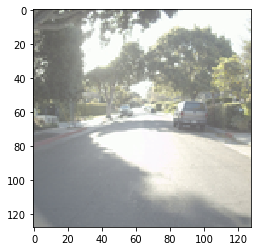

In [0]:
from PIL import Image
from PIL import ImageOps

import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

'''
def common_images(RGB_dir,Thermal_dir):
  RGB_image_list = os.listdir(RGB_dir)
  Thermal_image_list = os.listdir(Thermal_dir)

  truncated_RGB_image_list = [RGB_image_name.strip('.jpg') for RGB_image_name in RGB_image_list]
  truncated_Thermal_image_list = [Thermal_image_name.strip('.jpeg') for Thermal_image_name in Thermal_image_list]

  common_list = set(truncated_RGB_image_list).intersection(truncated_Thermal_image_list)
  common_list = sorted(common_list) # Nawid - Sorts all the items in a list
  return common_list

RGB_inp_dir = '/content/gdrive/My Drive/RGB'
Thermal_inp_dir = '/content/gdrive/My Drive/thermal_8_bit'
train_list = common_images(RGB_inp_dir,Thermal_inp_dir) 

val_RGB_inp_dir = '/content/gdrive/My Drive/Val_RGB'
val_Thermal_inp_dir = '/content/gdrive/My Drive/Val_thermal_8_bit'
val_list = common_images(val_RGB_inp_dir,val_Thermal_inp_dir)
'''


def processing_saving_images(modality,quick_test=True,Train_required=False,Val_required=True):
  all_images = []
  val_all_images = []
  
  if modality == 'RGB_':
    suffix = '.jpg'
    channels = 3
    inp_dir = '/content/gdrive/My Drive/RGB'
    val_inp_dir = '/content/gdrive/My Drive/Val_RGB'
  
  elif modality == 'Thermal_':
    suffix = '.jpeg'
    channels = 1
    inp_dir = '/content/gdrive/My Drive/thermal_8_bit'
    val_inp_dir = '/content/gdrive/My Drive/Val_thermal_8_bit'
  
  else:
    return('Incorrect Modality name')

  if quick_test:
    if Train_required:
      for i, img_name in enumerate(train_list):
        if i< 10:
          fname = inp_dir + '/' + img_name + suffix
          if modality == 'RGB_':
            image = image_utils.load_img(fname).resize(target_size,Image.ANTIALIAS)
          else:
            image = image_utils.load_img(fname,color_mode='grayscale').resize(target_size,Image.ANTIALIAS)
          
#          plt.imshow(image)
          image = np.array(image.getdata()).reshape(target_size[0], target_size[1],channels)
          img2 = np.fliplr(image)
          plt.imshow(image)
          print(img2.shape)

          #img2 = np.fliplr(image)
          
          #plt.imshow(img2)

          #image = np.array(image.getdata()).reshape(target_size[0], target_size[1], channels)
          #print("This is image",image.shape)
          

          #img2 = np.fliplr(image)
          #print("This is flipped image",img2.shape)
          #plt.imshow(image)
          
#          plt.imshow(img2)
          #print(image)
          #print(img2)
          #plt.imshow(img2)
          '''
          im = ImageOps.mirror(image)
          im.show()
          plt.imshow(image)
          plt.imshow(im)
          '''
          
    '''
          image = np.array(image.getdata()).reshape(target_size[0], target_size[1], channels)
          image = image.astype('float32')/255 
          all_images.append(image)
        else:
          pass
    else:
      pass
    '''
modality = 'RGB_'
processing_saving_images(modality,quick_test=True,Train_required=True,Val_required=False)


In [0]:
'''
import os
path = 'Data_folder'
os.mkdir(path)
'''
import os
from datetime import datetime
# datetime object containing current date and time
now = datetime.now()
dt_string = now.strftime("%d%m%Y_%H:%M:%S")
path = 'Data_folder_'
os.mkdir(path+dt_string)
'''
print("now =", now)
# dd/mm/YY H:M:S

print("date and time =", dt_string)	
'''

'\nprint("now =", now)\n# dd/mm/YY H:M:S\n\nprint("date and time =", dt_string)\t\n'

In [0]:
def main():
  model = make_vae()
  if os.path.exists(VAE_PATH):
    model.load_state_dict(torch.load(VAE_PATH, map_location='cpu'))
  model.to(device)
  optimizer = optim.Adam(model.parameters())
  
  # Nawid -Define the iterators for the validation data

  i = 0
  val_loader = InfiniteDataLoader(x_rgb,x)
  val_iterator = iter(val_loader) 

  

  for x_rgb_batch, x_thermal_batch in rgb_thermal_load_images(x_rgb,x):
    x_rgb_batch = x_rgb_batch.to(device)
    x_thermal_batch = x_thermal_batch.to(device)
    terms = model(x_rgb_batch, x_thermal_batch)
    
    if rapid_evaluation:
      print('step %d: mse=%f mse_top=%f' %
            (i, terms['losses'][-1].item(), terms['losses'][0].item()))
    else:
      if not i % eval_counter:
        print('step %d: mse=%f mse_top=%f' %
            (i, terms['losses'][-1].item(), terms['losses'][0].item()))
    
    optimizer.zero_grad() #Nawid - I think this makes the gradient become zero
    terms['loss'].backward() # Nawid - Backpropagates the total loss term ( which is related to all the different components)
    optimizer.step() # Nawid- Updates using optimizer
    model.revive_dead_entries()
    i +=1
    
    if not i % 50:
      torch.save(model.state_dict(), VAE_PATH)
      #save_reconstructions(x_rgb_batch, terms['reconstructions'][-1], x_thermal_batch,terms['reconstructions_thermal'][-1])
      save_reconstructions(model,x_rgb_batch, x_thermal_batch) # Nawid - saves the reconstruction

      val_rgb_batch,val_thermal_batch = next(val_iterator)
      
      if save_data:
        val_total_loss, val_reconstruction_loss = validation_loss(model,val_rgb_batch,val_thermal_batch)
        tensorboard_saving(i,terms['losses'][-1],val_reconstruction_loss, terms['loss'],val_total_loss)
      else:
        pass
      save_reconstructions(model,val_rgb_batch, val_thermal_batch,'Val')


def tensorboard_saving(iteration,recon_loss_train, recon_loss_val, total_loss_train,total_loss_val):
  tb.save_value('Reconstruction_loss','Train loss', iteration, recon_loss_train)
  tb.save_value('Reconstruction_loss','Validation loss', iteration, recon_loss_val)
      
  tb.save_value('Total_loss','Train loss', iteration, total_loss_train)
  tb.save_value('Total_loss','Validation loss', iteration, total_loss_val)
 
  tb.flush_line('Reconstruction_loss')
  tb.flush_line('Total_loss')


def validation_loss(vae,val_rgb, val_thermal):
  vae.eval() # Nawid - Sets it into evaluation mode ( so dropout and batchnorm have different behaviours)
  with torch.no_grad(): # Nawid-  Turns off the autograd engine which speeds up computation
    val_terms = vae(val_rgb,val_thermal)
    total_loss, reconstruction_loss = val_terms['loss'], val_terms['losses'][-1]
    vae.train()
    return total_loss, reconstruction_loss


def save_reconstructions(vae,rgb_images, thermal_images,name = 'Train'):
  vae.eval()
  with torch.no_grad():
    recons, recons_thermal = vae.full_reconstructions(rgb_images,thermal_images)
    recons = [torch.clamp(x, 0, 1).permute(0, 2, 3, 1).detach().cpu().numpy()
                  for x in recons] # Nawid - Clamps all the different elements in recons
    recons_thermal = [torch.clamp(x_thermal, 0, 1).permute(0, 2, 3, 1).detach().cpu().numpy()
                  for x_thermal in recons_thermal] # Nawid - Clamps all the different elements in recons_thermal
    
    vae.train() # Nawid - This sets the nn.module into training mode
    top_recons, real_recons = recons # Nawid - I believe the top_recons is the reconstruction using only the top latent map, whilst real_recons is using both the top latent map and the bottom latent map
    rgb_images = rgb_images.permute(0, 2, 3, 1).detach().cpu().numpy()
    columns = np.concatenate([top_recons, real_recons, rgb_images], axis=-2)
    columns = np.concatenate(columns, axis=0)
    Image.fromarray((columns * 255).astype('uint8')).save(name +'_reconstructions_rgb.png') # Nawid - Changes the valeus back to 255 and integers and save the reconstructions

    top_recons_thermal,real_recons_thermal = recons_thermal
    thermal_images = thermal_images.permute(0,2,3,1).detach().cpu().numpy()
    thermal_images = thermal_images.reshape(thermal_images.shape[0],thermal_images.shape[1],thermal_images.shape[2])

    top_recons_thermal = top_recons_thermal.reshape(top_recons_thermal.shape[0],top_recons_thermal.shape[1],top_recons_thermal.shape[2])
    real_recons_thermal = real_recons_thermal.reshape(real_recons_thermal.shape[0],real_recons_thermal.shape[1],real_recons_thermal.shape[2])

    columns_thermal = np.concatenate([top_recons_thermal, real_recons_thermal,thermal_images], axis=-1) # Nawid - I need to concatenate along -2 when using rgb and -1 when using grayscale and when using  When using grayscale images, to save the files using PIL, i need to make to remove the channel and so there is one less axis to examine
    columns_thermal = np.concatenate(columns_thermal, axis=0)
    Image.fromarray((columns_thermal * 255).astype('uint8')).save(name +'_reconstructions_thermal.png') # Nawid - Changes the valeus back to 255 and integers and save the reconstructions


main()

In [0]:
def main():
  model = make_vae()
  if os.path.exists(VAE_PATH):
    model.load_state_dict(torch.load(VAE_PATH, map_location='cpu'))
  model.to(device)
  optimizer = optim.Adam(model.parameters())
  
  # Nawid -Define the iterators for the validation data
  val_rgb_loader = InfiniteDataLoader(val_x_rgb)
  val_rgb_iterator = iter(val_rgb_loader)

  val_thermal_loader = InfiniteDataLoader(val_x)
  val_thermal_iterator = iter(val_thermal_loader)

  i = 0
  for x_rgb_batch, x_thermal_batch in zip(load_images(x_rgb), load_images(x)):
    x_rgb_batch= x_rgb_batch.to(device)
    x_thermal_batch =  x_thermal_batch.to(device)
    terms = model(x_rgb_batch, x_thermal_batch)
    
    if rapid_evaluation:
      print('step %d: mse=%f mse_top=%f' %
            (i, terms['losses'][-1].item(), terms['losses'][0].item()))
    else:
      if not i % eval_counter:
        print('step %d: mse=%f mse_top=%f' %
            (i, terms['losses'][-1].item(), terms['losses'][0].item()))
    
    optimizer.zero_grad() #Nawid - I think this makes the gradient become zero
    terms['loss'].backward() # Nawid - Backpropagates the total loss term ( which is related to all the different components)
    optimizer.step() # Nawid- Updates using optimizer
    model.revive_dead_entries()
    i +=1
    if not i % 50:
      torch.save(model.state_dict(), VAE_PATH)
      #save_reconstructions(x_rgb_batch, terms['reconstructions'][-1], x_thermal_batch,terms['reconstructions_thermal'][-1])
      save_reconstructions(model,x_rgb_batch, x_thermal_batch) # Nawid - saves the reconstruction

      val_rgb_batch = next(val_rgb_iterator)
      val_thermal_batch = next(val_thermal_iterator)
      val_total_loss, val_reconstruction_loss = validation_loss(model,val_rgb_batch,val_thermal_batch)
      
      tensorboard_saving(i,terms['losses'][-1],val_reconstruction_loss, terms['loss'],val_total_loss)
      save_reconstructions(model,val_rgb_batch, val_thermal_batch,'Val')

      '''
      tb.save_value('Reconstruction_loss','Train loss', i, terms['losses'][-1])
      tb.save_value('Reconstruction_loss','Validation loss', i, val_reconstruction_loss)
      
      tb.save_value('Total_loss','Train loss', i, terms['loss'])
      tb.save_value('Total_loss','Validation loss', i, val_total_loss)
      tb.flush_line('Reconstruction_loss')
      tb.flush_line('Total_loss')
      '''
      

def tensorboard_saving(iteration,recon_loss_train, recon_loss_val, total_loss_train,total_loss_val):
  tb.save_value('Reconstruction_loss','Train loss', iteration, recon_loss_train)
  tb.save_value('Reconstruction_loss','Validation loss', iteration, recon_loss_val)
      
  tb.save_value('Total_loss','Train loss', iteration, total_loss_train)
  tb.save_value('Total_loss','Validation loss', iteration, total_loss_val)
 
  tb.flush_line('Reconstruction_loss')
  tb.flush_line('Total_loss')


def validation_loss(vae,val_rgb, val_thermal):
  vae.eval() # Nawid - Sets it into evaluation mode ( so dropout and batchnorm have different behaviours)
  with torch.no_grad(): # Nawid-  Turns off the autograd engine which speeds up computation
    val_terms = vae(val_rgb,val_thermal)
    total_loss, reconstruction_loss = val_terms['loss'], val_terms['losses'][-1]
    return total_loss, reconstruction_loss


def save_reconstructions(vae,rgb_images, thermal_images,name = 'Train'):
  vae.eval()
  with torch.no_grad():
    recons, recons_thermal = vae.full_reconstructions(rgb_images,thermal_images)
    recons = [torch.clamp(x, 0, 1).permute(0, 2, 3, 1).detach().cpu().numpy()
                  for x in recons] # Nawid - Clamps all the different elements in recons
    recons_thermal = [torch.clamp(x_thermal, 0, 1).permute(0, 2, 3, 1).detach().cpu().numpy()
                  for x_thermal in recons_thermal] # Nawid - Clamps all the different elements in recons_thermal
    
    vae.train() # Nawid - This sets the nn.module into training mode
    top_recons, real_recons = recons # Nawid - I believe the top_recons is the reconstruction using only the top latent map, whilst real_recons is using both the top latent map and the bottom latent map
    rgb_images = rgb_images.permute(0, 2, 3, 1).detach().cpu().numpy()
    columns = np.concatenate([top_recons, real_recons, rgb_images], axis=-2)
    columns = np.concatenate(columns, axis=0)
    Image.fromarray((columns * 255).astype('uint8')).save(name +'_reconstructions_rgb.png') # Nawid - Changes the valeus back to 255 and integers and save the reconstructions

    top_recons_thermal,real_recons_thermal = recons_thermal
    thermal_images = thermal_images.permute(0,2,3,1).detach().cpu().numpy()
    thermal_images = thermal_images.reshape(thermal_images.shape[0],thermal_images.shape[1],thermal_images.shape[2])

    top_recons_thermal = top_recons_thermal.reshape(top_recons_thermal.shape[0],top_recons_thermal.shape[1],top_recons_thermal.shape[2])
    real_recons_thermal = real_recons_thermal.reshape(real_recons_thermal.shape[0],real_recons_thermal.shape[1],real_recons_thermal.shape[2])

    columns_thermal = np.concatenate([top_recons_thermal, real_recons_thermal,thermal_images], axis=-1) # Nawid - I need to concatenate along -2 when using rgb and -1 when using grayscale and when using  When using grayscale images, to save the files using PIL, i need to make to remove the channel and so there is one less axis to examine
    columns_thermal = np.concatenate(columns_thermal, axis=0)
    Image.fromarray((columns_thermal * 255).astype('uint8')).save(name +'_reconstructions_thermal.png') # Nawid - Changes the valeus back to 255 and integers and save the reconstructions

main()

In [0]:
def load_images(input_x): # Nawid - Loads images
    while True:
        for data in create_data_loader(input_x):
          #data = data.float()/255 # Nawid - Divides by 255 
          data = data.permute(0, 3, 1, 2).contiguous() # Nawid - Changes into pytorch ordering
          yield data
       
def create_data_loader(input_x): # Nawid - Creates a dataloader object
    return torch.utils.data.DataLoader(input_x, batch_size=BATCH_SIZE, shuffle=True)

# https://gist.github.com/MFreidank/821cc87b012c53fade03b0c7aba13958
class InfiniteDataLoader(DataLoader): 
  def __init__(self,input_x, batch_size=BATCH_SIZE, shuffle=True):
    super().__init__(input_x, batch_size=BATCH_SIZE, shuffle=True)
    #Initialise an iterator over the dataset
    self.dataset_iterator = super().__iter__()

  def __iter__(self):
    return self

  def __next__(self):
    try:
      batch = next(self.dataset_iterator)

    except StopIteration:
      # Dataset exhausted, use a new fresh iterator
      self.dataset_iterator = super().__iter__()
      batch = next(self.dataset_iterator)
    batch = batch.permute(0, 3, 1, 2).contiguous() # Nawid- Added this to change the channels
    return batch.to(device) # Nawid - Add to the device directly




In [0]:
def rgb_thermal_load_images_patch(input_rgb, input_thermal): # Nawid - Loads images
    while True:
        for (rgb_data,thermal_data) in rgb_thermal_data_loader(input_rgb,input_thermal):
          #data = data.float()/255 # Nawid - Divides by 255 
          rgb_data = rgb_data.permute(0, 3, 1, 2).contiguous() # Nawid - Changes into pytorch ordering
          rgb_data[:,:,target_size[0]//2:target_size[0]//2 + 10, target_size[1]//2: target_size[1]//2 + 10] = 1
          #rgb_data[0,0,0:64,0:64] = 1
          print(rgb_data[0,0])
#          print(rgb_data[0,0,0:10,0:10])
          thermal_data = thermal_data.permute(0, 3, 1, 2).contiguous()
          yield rgb_data, thermal_data

x_rgb_patch = x_rgb[0:100]
x_thermal_patch = x[0:100]

target_size[0]//2
target_size[1]//2 





def missing_modality_patch(modal_input): # Nawid - Modal output related to changing a single patch of the image 
  target = modal_input
  modal_input.new_full((modal_input.size()),-1)
  #modal_input[:,:,:,:] = -1
  #modal_input[:,:,target_size[0]//2:target_size[0]//2 + 10, target_size[1]//2: target_size[1]//2 + 10] = -1
  return modal_input, target

single_data_point = x_rgb[0:2]
missing_patch, target = missing_modality_patch(single_data_point)
print(missing_patch)

'''
height_start = random.randint(0, target_size[0])
height_end = random.randint(height_start, target_size[0]) 
width_start = random.randint(0,target_size[1])
width_end = random.randint(width_start, target_size[1])
print(height_start,height_end)
'''

'''
for x_rgb_batch, x_thermal_batch in rgb_thermal_load_images_patch(x_rgb,x):
  x_rgb_batch
'''

In [0]:
#height_list = random.sample(range(1, target_size[0]), 60)
#width_list = random.sample(range(1, target_size[0]), 60)

height_list = [random.randint(0,target_size[0]-1) for i in range(100)]
width_list = [random.randint(0,target_size[0]-1) for i in range(100)]

In [0]:
l_height = [random.randint(0,target_size[0]-1) for i in range(100)]
#print(l_height)
values = list(range(0, target_size[0]))



x = np.load('/content/gdrive/My Drive/Thermal_'+str(target_size[0]) + 'x' + str(target_size[1]) + '_images.npy')
single_data_point = x[0:1]
low_value_list = [x for x in single_data_point > 1]
print(low_value_list)
#for i in single_data_point:
   


#single_data_point[:,[1,2,3],[0,1,2],:] = -10
#print(single_data_point[:,[1,2,3],[2],:])
#print(single_data_point[:,0:4,0:4:])


#print(single_data_point[:,1,1,:])
#print(single_data_point)



In [0]:
l_height = [random.randint(0,target_size[0]-1) for i in range(64)]
#print(l_height)

values = list(range(0, target_size[0]))

single_data_point = x_rgb[0:2]

single_data_point[:,[1,2,3],[1,1,1],:] = 1

print(single_data_point[:,1:3,1:3,:])
#print(single_data_point)